# New York City Taxi Fare Prediction 

## ML Training and Prediction in Liten Cache
* Liten database can serve in batch and maintain versions using a multi-version control system
* It integrates data from different sources that Data Science/ML engineer need not worry about
* Cognitive Services - Trained models performing predictive actions for target markets
* ML Operations 
    * Data serving in batches
    * Model, Features, Embeddings versions and registering
    * Deployment with single statements on different clouds

XG Boost example here shows the following
* train using XGBoost in pandas
* predict using models in liten

Import pandas, xgboost, arrow and liten

In [1]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm

import pyarrow as pa
from pyarrow import csv
import litendb as ten

I20251020 12:34:15.573678 673396 TCache.cpp:25] Created a new TCache


## Data cleaning & Feature engineering Methods

In [2]:
df = pd.DataFrame()
df.dropna()

""


In [3]:
def remove_outliers(df):
    df = df.dropna()
    mask = df['fare_amount'].between(0, 500)
    mask &= df['passenger_count'].between(0, 6)

    # to select coordinates: https://www.openstreetmap.org/export
    mask &= df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)

    return df[mask]

def manhattan(pickup, dropoff):
    pickup_long, pickup_lat = pickup
    dropoff_long, dropoff_lat = dropoff
    return np.abs(dropoff_long - pickup_long) + np.abs(dropoff_lat - pickup_lat)

def extract_distance_features(df):
    df['abs_diff_longitude'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()
    df['abs_diff_latitude'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()

    pickup = (df['pickup_longitude'], df['pickup_latitude'])
    dropoff = (df['dropoff_longitude'], df['dropoff_latitude'])
    df['distance'] = manhattan(pickup, dropoff)

    # Distances to nearby airports, and city center
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    coordinates = {
        'nyc': (-74.0063889, 40.7141667),
        'jfk': (-73.7822222222, 40.6441666667),
        'ewr': (-74.175, 40.69),
        'lgr': (-73.87, 40.77)
    }

    for name, coord in coordinates.items():
        df[f'pickup_distance_to_{name}'] = manhattan(coord, pickup)
        df[f'dropoff_distance_to_{name}'] = manhattan(coord, dropoff)

    return df

def extract_datetime_features(df):
    # Removing unecessary information from the datetime string
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    pickup_datetime = df['pickup_datetime'].str.slice(0, 16)
    pickup_datetime = pd.to_datetime(pickup_datetime, utc=True, format='%Y-%m-%d %H:%M')

    df['year'] = pickup_datetime.dt.year
    df['month'] = pickup_datetime.dt.month
    df['day'] = pickup_datetime.dt.day
    df['dayofweek'] = pickup_datetime.dt.dayofweek
    df['hour'] = pickup_datetime.dt.hour

    return df.drop(columns='pickup_datetime')

def extract_features(df):
    df = extract_distance_features(df)
    df = extract_datetime_features(df)
    return df

### Add arrow csv to liten cache
Create a new cache, add NY Taxi data to cache

In [4]:
tc = ten.Cache()

In [5]:
import os
from huggingface_hub import snapshot_download
dataset = 'nyyellowtaxi'
local_dir=f'./{dataset}/'
if not os.path.exists(local_dir):
    print(f'Downloading dataset into {local_dir} ...')
    snapshot_download(
        repo_id="hkverma/"+dataset,
        repo_type="dataset",
        local_dir=local_dir,
        local_dir_use_symlinks=False  # ensures real copies, not symlinks
    )
    print('Download Complete.')
else:
    print(f"Dataset already exists in {local_dir}, skipping download.")  
nytaxi_data_dir=local_dir
os.listdir(nytaxi_data_dir)
nytaxi_train_file = nytaxi_data_dir+'train.csv'

Dataset already exists in ./nyyellowtaxi/, skipping download.


In [6]:
convert_schema = pa.csv.ConvertOptions(
    column_types={
        'fare_amount': 'float32',
        'pickup_datetime': 'string',
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'uint8'
    }
)
train_pa = pa.csv.read_csv(input_file=nytaxi_train_file, convert_options=convert_schema)
table_name = tc.add_table("nyt_train", train_pa, tc.FactTable)

I20251020 12:34:15.780746 673396 TCatalog.cpp:15] Created a new TCatalog


In [7]:
tc.info()

I20251020 12:34:15.785006 673396 TConfigs.cpp:17] Created a new TConfigs


b'{"Compute":{"WorkerThreads":0},"Table":{"nyt_train":"FactTable"},"Schema":{"nyt_train_schema":"FactTable"}}'

Create val pandas df for XGBoost

In [8]:
val_size=100
dtypes = {'fare_amount': 'float32',
          'pickup_datetime': 'str',
          'pickup_longitude': 'float32',
          'pickup_latitude': 'float32',
          'dropoff_longitude': 'float32',
          'dropoff_latitude': 'float32',
          'passenger_count': 'uint8'}

input_file = nytaxi_data_dir+'train.csv'
   
val_df = tc.slice(table_name="nyt_train", offset=0,length=val_size).to_pandas()
val_df = remove_outliers(val_df)
val_df = extract_features(val_df)
val_df = val_df.drop(columns='key')

X_val = val_df.drop(columns='fare_amount')
y_val = val_df[['fare_amount']]

dval = xgb.DMatrix(X_val, y_val, feature_names=X_val.columns.tolist())

## Batch training 
Read batched data using Liten data tensor slices

In [9]:
params = {'learning_rate': 0.05,
          'max_depth': 7,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'subsample': 0.8,
          'gamma': 1,
          'silent': True,
          'verbose_eval': True}
num_rounds = 16
model = None
batch_size = 1000
val_size = 100
    
remaining_rows = train_pa.num_rows - val_size
offset = val_size

while (remaining_rows > 0):
    batch_df = tc.slice(table_name="nyt_train", offset=offset, length=batch_size).to_pandas()
    remaining_rows -= batch_size
    offset += batch_size
    
    batch_df = remove_outliers(batch_df)
    batch_df = extract_features(batch_df)

    batch_df = batch_df.drop(columns='key')
    X_train = batch_df.drop(columns='fare_amount')
    y_train = batch_df[['fare_amount']]
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns.tolist())
    
    model = xgb.train(params, dtrain, num_rounds, early_stopping_rounds=5,
                      evals=[(dtrain, 'train'), (dval, 'eval')],
                      xgb_model=model)

[0]	train-rmse:9.24294	eval-rmse:7.44293
[1]	train-rmse:8.88162	eval-rmse:7.21050
[2]	train-rmse:8.53281	eval-rmse:6.96350
[3]	train-rmse:8.19290	eval-rmse:6.74959
[4]	train-rmse:7.87642	eval-rmse:6.55970
[5]	train-rmse:7.57110	eval-rmse:6.34366
[6]	train-rmse:7.28417	eval-rmse:6.18975
[7]	train-rmse:7.02181	eval-rmse:6.04495
[8]	train-rmse:6.76513	eval-rmse:5.89536
[9]	train-rmse:6.52336	eval-rmse:5.75504
[10]	train-rmse:6.30733	eval-rmse:5.64198
[11]	train-rmse:6.08585	eval-rmse:5.54015


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	train-rmse:5.87302	eval-rmse:5.44881
[13]	train-rmse:5.68796	eval-rmse:5.34398
[14]	train-rmse:5.50615	eval-rmse:5.27247
[15]	train-rmse:5.32473	eval-rmse:5.18529
[0]	train-rmse:8.66847	eval-rmse:5.11888
[1]	train-rmse:8.48188	eval-rmse:5.03724
[2]	train-rmse:8.21055	eval-rmse:4.97613
[3]	train-rmse:7.94388	eval-rmse:4.90869
[4]	train-rmse:7.77101	eval-rmse:4.81201
[5]	train-rmse:7.58868	eval-rmse:4.75831
[6]	train-rmse:7.34246	eval-rmse:4.71757
[7]	train-rmse:7.09964	eval-rmse:4.65584
[8]	train-rmse:6.88059	eval-rmse:4.62748
[9]	train-rmse:6.79712	eval-rmse:4.58236


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	train-rmse:6.66495	eval-rmse:4.52441
[11]	train-rmse:6.53639	eval-rmse:4.50280
[12]	train-rmse:6.32632	eval-rmse:4.48455
[13]	train-rmse:6.13431	eval-rmse:4.47197
[14]	train-rmse:6.01574	eval-rmse:4.45109
[15]	train-rmse:5.82760	eval-rmse:4.41537


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4.48658	eval-rmse:4.36306
[1]	train-rmse:4.38438	eval-rmse:4.31690
[2]	train-rmse:4.28506	eval-rmse:4.28485
[3]	train-rmse:4.20847	eval-rmse:4.31641
[4]	train-rmse:4.11884	eval-rmse:4.34871
[5]	train-rmse:4.04612	eval-rmse:4.33199
[6]	train-rmse:3.94958	eval-rmse:4.30983
[7]	train-rmse:3.88334	eval-rmse:4.27674
[8]	train-rmse:3.80676	eval-rmse:4.25314
[9]	train-rmse:3.73442	eval-rmse:4.25275
[10]	train-rmse:3.67988	eval-rmse:4.23737
[11]	train-rmse:3.61743	eval-rmse:4.21498
[12]	train-rmse:3.54542	eval-rmse:4.22263
[13]	train-rmse:3.49053	eval-rmse:4.22054
[14]	train-rmse:3.43279	eval-rmse:4.21482
[15]	train-rmse:3.37822	eval-rmse:4.19944


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4.05523	eval-rmse:4.19601
[1]	train-rmse:3.97744	eval-rmse:4.19724
[2]	train-rmse:3.89247	eval-rmse:4.21230
[3]	train-rmse:3.82245	eval-rmse:4.21831
[4]	train-rmse:3.76699	eval-rmse:4.21377
[5]	train-rmse:3.70642	eval-rmse:4.21798
[0]	train-rmse:4.58861	eval-rmse:4.20925
[1]	train-rmse:4.46297	eval-rmse:4.17412
[2]	train-rmse:4.39519	eval-rmse:4.11620
[3]	train-rmse:4.34086	eval-rmse:4.07557
[4]	train-rmse:4.30192	eval-rmse:4.04295
[5]	train-rmse:4.24188	eval-rmse:4.05752
[6]	train-rmse:4.14501	eval-rmse:4.06533
[7]	train-rmse:4.08514	eval-rmse:4.06777
[8]	train-rmse:4.05129	eval-rmse:4.07434
[9]	train-rmse:3.96023	eval-rmse:4.07872


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)
/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4.26618	eval-rmse:4.07658
[1]	train-rmse:4.21396	eval-rmse:4.07753
[2]	train-rmse:4.14167	eval-rmse:4.04605
[3]	train-rmse:4.06584	eval-rmse:4.04816
[4]	train-rmse:3.98642	eval-rmse:4.05272
[5]	train-rmse:3.92508	eval-rmse:4.07451
[6]	train-rmse:3.84817	eval-rmse:4.06438
[7]	train-rmse:3.79933	eval-rmse:4.06656


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4.67295	eval-rmse:4.03379
[1]	train-rmse:4.59055	eval-rmse:4.01315
[2]	train-rmse:4.50918	eval-rmse:4.00667
[3]	train-rmse:4.41942	eval-rmse:3.97315
[4]	train-rmse:4.32315	eval-rmse:3.97519
[5]	train-rmse:4.24359	eval-rmse:3.97988
[6]	train-rmse:4.20314	eval-rmse:4.03005
[7]	train-rmse:4.11633	eval-rmse:4.04452
[8]	train-rmse:4.03314	eval-rmse:4.00444


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4.28286	eval-rmse:4.01273
[1]	train-rmse:4.22074	eval-rmse:4.02080
[2]	train-rmse:4.16246	eval-rmse:4.02665
[3]	train-rmse:4.09214	eval-rmse:4.04980
[4]	train-rmse:4.01079	eval-rmse:4.04975


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4.22101	eval-rmse:4.05964
[1]	train-rmse:4.14121	eval-rmse:4.09370
[2]	train-rmse:4.06174	eval-rmse:4.09342
[3]	train-rmse:3.99739	eval-rmse:4.09292
[4]	train-rmse:3.91824	eval-rmse:4.09969
[0]	train-rmse:3.54042	eval-rmse:4.10541
[1]	train-rmse:3.47436	eval-rmse:4.07336
[2]	train-rmse:3.40942	eval-rmse:4.05051
[3]	train-rmse:3.34618	eval-rmse:4.05088
[4]	train-rmse:3.31372	eval-rmse:4.06304
[5]	train-rmse:3.26867	eval-rmse:4.04785
[6]	train-rmse:3.21180	eval-rmse:4.02678
[7]	train-rmse:3.15729	eval-rmse:4.00398
[8]	train-rmse:3.11227	eval-rmse:4.00230
[9]	train-rmse:3.08313	eval-rmse:4.00425
[10]	train-rmse:3.04583	eval-rmse:4.00429
[11]	train-rmse:3.01688	eval-rmse:3.98663
[12]	train-rmse:2.97821	eval-rmse:3.98499
[13]	train-rmse:2.93372	eval-rmse:3.99110
[14]	train-rmse:2.88817	eval-rmse:3.98087
[15]	train-rmse:2.86153	eval-rmse:3.96897


/home/hkverma/venvs/liten/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:34:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent", "verbose_eval" } are not used.

  warnings.warn(smsg, UserWarning)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

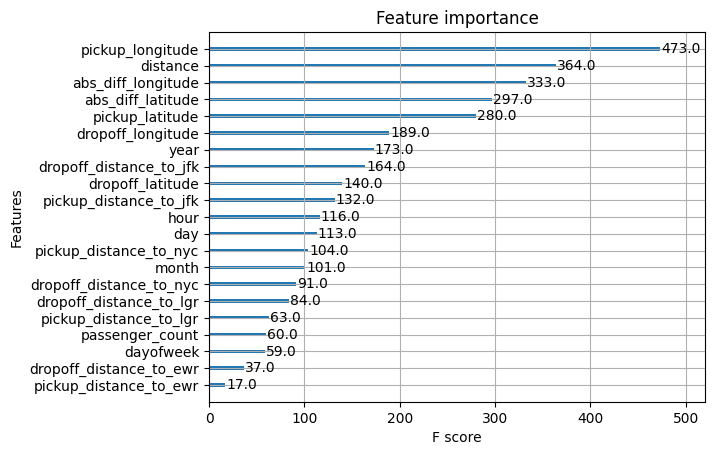

In [10]:
xgb.plot_importance(model)

## Predictions
Read test data from liten, add predicted columns. Prediction is to be added as Liten method as well.

In [11]:
nytaxi_test_file = nytaxi_data_dir+'test.csv'
convert_schema = pa.csv.ConvertOptions(
    column_types={
        'key': 'string',
        'pickup_datetime': 'string',
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'uint8'
    }
)
test_pa = pa.csv.read_csv(input_file=nytaxi_test_file, convert_options=convert_schema)
table_name = tc.add_table("nyt_test", test_pa, tc.FactTable)

In [12]:
test_pa = tc.slice(table_name="nyt_test", offset=0, length=20)
test_df = test_pa.to_pandas()
test_df = extract_features(test_df)
test_df.dtypes

key                         object
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count              uint8
abs_diff_longitude         float32
abs_diff_latitude          float32
distance                   float32
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
year                         int32
month                        int32
day                          int32
dayofweek                    int32
hour                         int32
dtype: object

In [13]:
X_test = test_df.drop(columns='key')
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns.tolist())
y_pred = model.predict(dtest)

In [14]:
pred_arr = pa.array(y_pred)
test_pa = test_pa.append_column('predicted_fare_amount', pred_arr)

In [15]:
test_pa.to_pandas()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,predicted_fare_amount
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,9.219719
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,9.293431
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982521,40.751259,-73.979652,40.746140,1,5.116846
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981163,40.767807,-73.990448,40.751637,1,7.896041
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966049,40.789776,-73.988564,40.744427,1,13.894969
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765549,-73.979179,40.740051,1,10.173482
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773205,-73.959625,40.770893,1,5.018968
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777283,40.646637,-73.985085,40.759369,1,44.906147
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.014099,40.709637,-73.995110,40.741364,1,12.011222
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20 UTC,-73.969582,40.765518,-73.980682,40.770725,1,6.416982
